# Forecasting with Temporal Fusion Transformers

In [1]:
import holidays
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import pickle

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.metrics import mean_absolute_error, mean_squared_error

Set the float32 matmul precision to high to speed up computation

In [2]:
torch.set_float32_matmul_precision('medium')

Read the dataframe

In [3]:
df = pd.read_csv('../data/renfe_tft/output.csv')
print(f'Number of passengers: {len(df)}')
df.head()

Number of passengers: 1906235


,id,user_pattern,departure_station,arrival_station,arrival_day,arrival_time,purchase_day,service,service_departure_time,service_arrival_time,seat,price,utility,best_service,best_seat,best_utility
0,489461,Business,60000,71801,2023-04-10,7.735071,10,03063_10-04-2023-06.30,6.5,9.333333,Premium,90.03,1.916529,03063_10-04-2023-06.30,Premium,1.916529
1,62082,Business,60000,71801,2023-01-09,6.833554,9,03063_09-01-2023-06.30,6.5,9.333333,Premium,71.95,4.271485,03063_09-01-2023-06.30,Premium,4.271485
2,448260,Business,60000,71801,2023-04-04,6.856650,9,03063_04-04-2023-06.30,6.5,9.333333,Premium,116.09,0.841291,03063_04-04-2023-06.30,Premium,0.841291
3,538920,Business,60000,71801,2023-04-17,7.877119,9,03063_17-04-2023-06.30,6.5,9.333333,Premium,71.62,3.484014,03063_17-04-2023-06.30,Premium,3.484014
4,571727,Business,60000,71801,2023-04-23,8.779342,9,03083_23-04-2023-08.30,8.5,11.250000,Premium,132.48,1.196724,03083_23-04-2023-08.30,Premium,1.196724


Drop passengers that don't buy a ticket

In [4]:
df = df[df['service'].notna()]
print(f'Number of passengers: {len(df)}')

Number of passengers: 617098


Convert arrival_day to datetime

In [5]:
df['arrival_day'] = pd.to_datetime(df['arrival_day'])

Group the passengers per seat and arrival day

In [6]:
df = df.groupby(by=['seat', 'arrival_day']).size().to_frame()
df

0
seat    arrival_day      
Basico  2023-01-01   2335
        2023-01-02   1600
        2023-01-03   1393
        2023-01-04   1142
        2023-01-05   1237
...                   ...
Premium 2023-12-27    200
        2023-12-28    200
        2023-12-29    600
        2023-12-30    250
        2023-12-31    453

[1086 rows x 1 columns]

Add missing dates and seats

In [7]:
df = df.unstack().fillna(0).stack()
df

0
seat    arrival_day        
Basico  2023-01-01   2335.0
        2023-01-02   1600.0
        2023-01-03   1393.0
        2023-01-04   1142.0
        2023-01-05   1237.0
...                     ...
Premium 2023-12-27    200.0
        2023-12-28    200.0
        2023-12-29    600.0
        2023-12-30    250.0
        2023-12-31    453.0

[1095 rows x 1 columns]

Rename the columns of the dataframe

In [8]:
df = df.reset_index()
df.columns = ['seat', 'arrival_day', 'tickets_sold']
df

,seat,arrival_day,tickets_sold
0,Basico,2023-01-01,2335.0
1,Basico,2023-01-02,1600.0
2,Basico,2023-01-03,1393.0
3,Basico,2023-01-04,1142.0
4,Basico,2023-01-05,1237.0
...,...,...,...
1090,Premium,2023-12-27,200.0
1091,Premium,2023-12-28,200.0
1092,Premium,2023-12-29,600.0
1093,Premium,2023-12-30,250.0


Add to the dataframe new features

Test include price, utility and other features

In [9]:
# Add time features
df['month'] = df['arrival_day'].dt.month
df['day'] = df['arrival_day'].dt.day
df['weekday'] = df['arrival_day'].dt.weekday
df['days_from_start'] = (df['arrival_day'] - df['arrival_day'].min()).dt.days

# Add holiday features
# TODO: Add regional and local holidays
es_holidays = holidays.ES()
df['national_holiday'] = df['arrival_day'].apply(lambda x: es_holidays.get(x) if x in es_holidays else 'X')
df

,seat,arrival_day,tickets_sold,month,day,weekday,days_from_start,national_holiday
0,Basico,2023-01-01,2335.0,1,1,6,0,X
1,Basico,2023-01-02,1600.0,1,2,0,1,X
2,Basico,2023-01-03,1393.0,1,3,1,2,X
3,Basico,2023-01-04,1142.0,1,4,2,3,X
4,Basico,2023-01-05,1237.0,1,5,3,4,X
...,...,...,...,...,...,...,...,...
1090,Premium,2023-12-27,200.0,12,27,2,360,X
1091,Premium,2023-12-28,200.0,12,28,3,361,X
1092,Premium,2023-12-29,600.0,12,29,4,362,X
1093,Premium,2023-12-30,250.0,12,30,5,363,X


Exploratory data analysis

In [10]:
df[['seat', 'tickets_sold']].groupby(by='seat').mean()

,tickets_sold
seat,
Basico,1176.347945
Elige,210.309589
Premium,304.021918


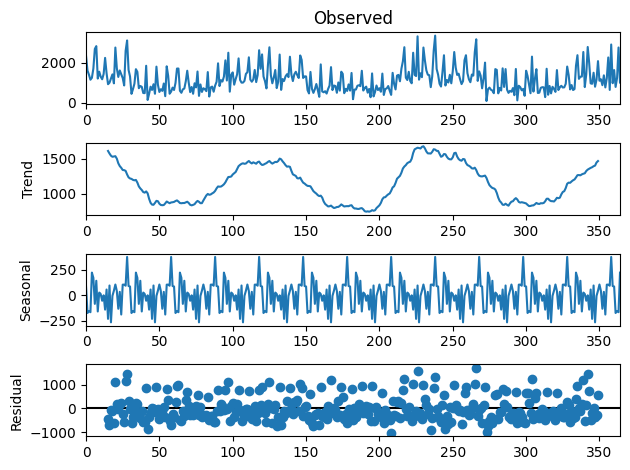

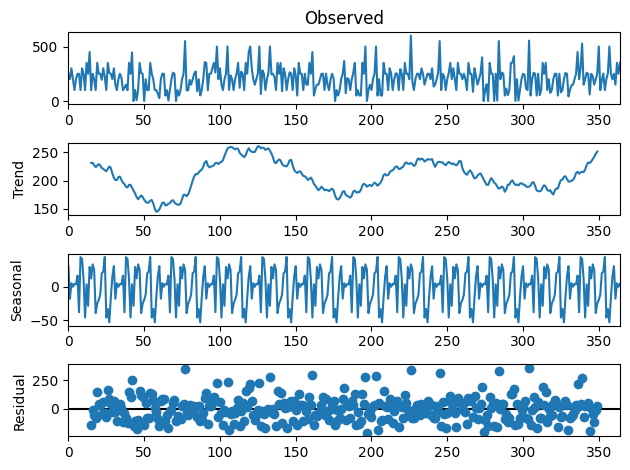

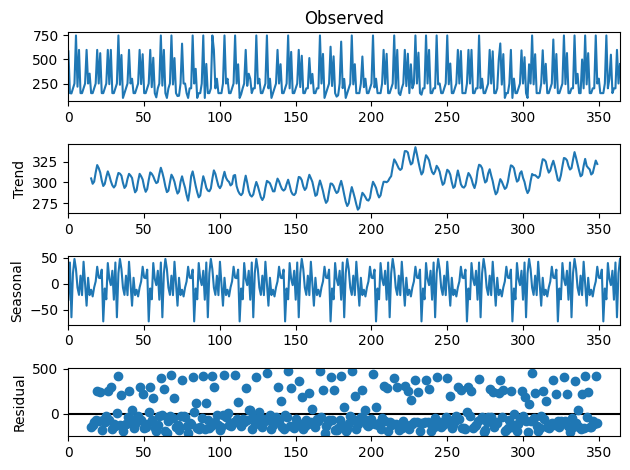

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = [value[0] for value in df[df['seat'] == 'Basico'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

series = [value[0] for value in df[df['seat'] == 'Elige'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

series = [value[0] for value in df[df['seat'] == 'Premium'][['tickets_sold']].values.tolist()]
result = seasonal_decompose(series, model='additive', period=30).plot()

Create training and validation time series dataset

In [12]:
min_prediction_length = 1 # We want to predict the next day
max_prediction_length = 3 # We want to predict the next 3 days
max_encoder_length = 4 * 7 # We want to use 4 weeks of data to predict the next 7 days
training_cutoff = df['days_from_start'].max() - max_prediction_length

In [13]:
training = TimeSeriesDataSet(
    df[lambda x: x.days_from_start <= training_cutoff],
    time_idx='days_from_start',
    target='tickets_sold',
    group_ids=['seat'],
    min_encoder_length=max_encoder_length // 2, # TODO: Check if this is correct
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['seat', 'national_holiday'],
    time_varying_known_reals=['days_from_start', 'day', 'weekday', 'month'],
    time_varying_unknown_reals=['tickets_sold'],
    target_normalizer=GroupNormalizer(groups=['seat'], transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

In [14]:
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

In [15]:
# Create dataloaders for our model
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=16)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=16)

In [16]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).cpu()
baseline_predictions = Baseline().predict(val_dataloader).cpu()
mae = mean_absolute_error(actuals, baseline_predictions)
mse = mean_squared_error(actuals, baseline_predictions)
print(f'Baseline MAE: {mae}')
print(f'Baseline MSE: {mse}')

/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 427.0
Baseline MSE: 494933.0


Train the TFT model

In [17]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=True, mode='min')
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger('lightning_logs')  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
--------------------------------------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 225.140


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 78.609 >= min_delta = 0.0001. New best score: 146.531


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.769 >= min_delta = 0.0001. New best score: 142.762


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.960 >= min_delta = 0.0001. New best score: 141.802


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.635 >= min_delta = 0.0001. New best score: 134.166


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.143 >= min_delta = 0.0001. New best score: 127.024


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.542 >= min_delta = 0.0001. New best score: 119.482


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.200 >= min_delta = 0.0001. New best score: 110.282


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 18.981 >= min_delta = 0.0001. New best score: 91.301


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 91.301. Signaling Trainer to stop.


In [18]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu()
predictions = tft.predict(val_dataloader).cpu()
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
print(f'Baseline MAE: {mae}')
print(f'Baseline MSE: {mse}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 178.8921661376953
Baseline MSE: 74288.5546875


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


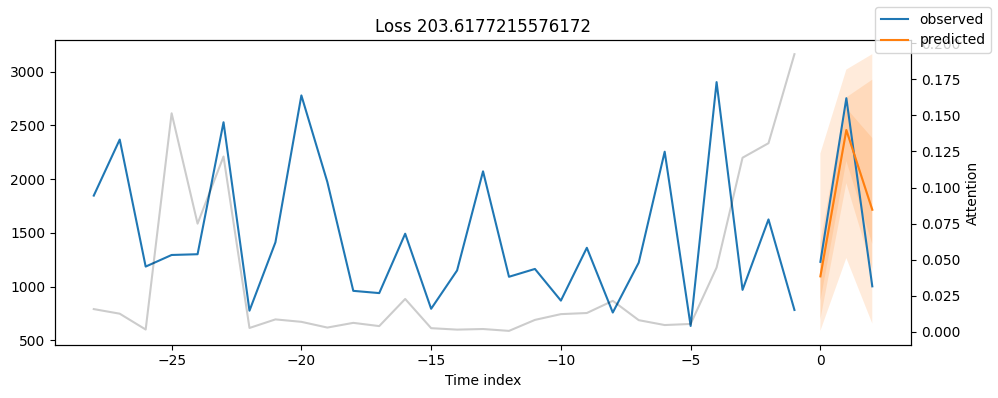

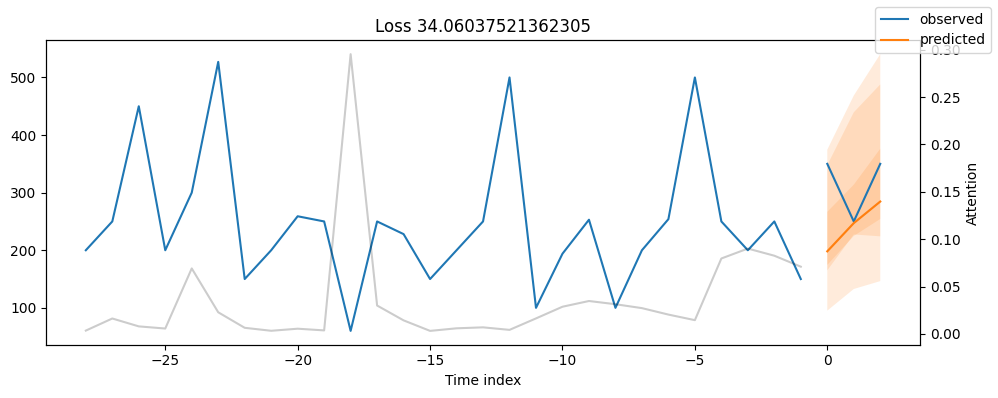

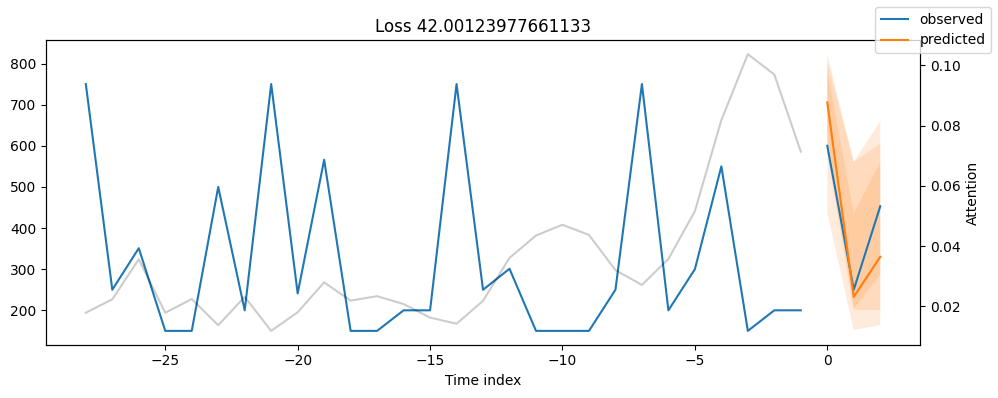

In [19]:
raw_predictions, x, _, _, _ = tft.predict(val_dataloader, mode='raw', return_x=True)
for idx in range(3):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x325 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

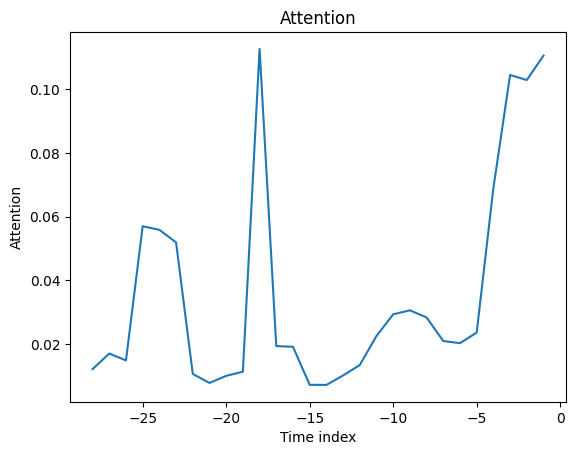

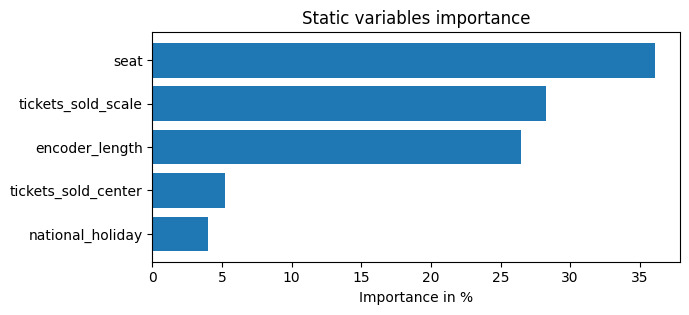

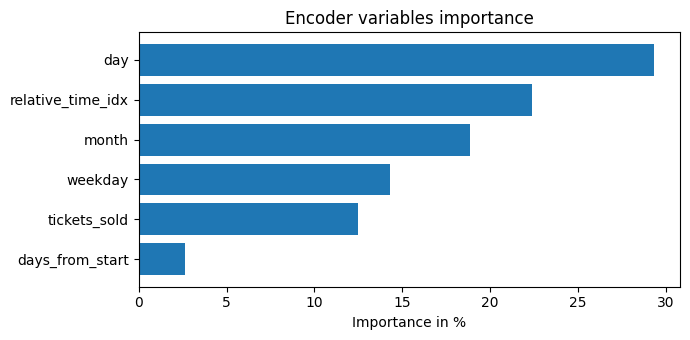

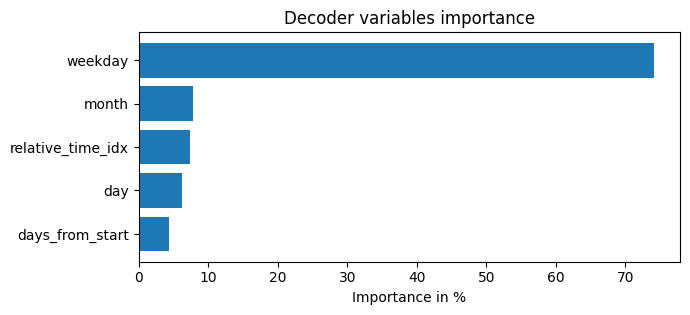

In [20]:
interpretation = tft.interpret_output(raw_predictions, reduction='sum')
tft.plot_interpretation(interpretation)

In [21]:
#Analysis on the val set

# predictions, x, _, _, _ = tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(x, predictions)
# tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [22]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path='optuna_test',
    n_trials=10,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False 
)

# save study results
with open('test_study.pkl', 'wb') as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

[I 2023-05-17 17:15:22,617] A new study created in memory with name: no-name-396d4636-bbc4-4eb4-b4c3-17bf8214e715
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:124: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kinrre/.virtualenvs/robin/lib/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

{'gradient_clip_val': 0.06943646895645751, 'hidden_size': 72, 'dropout': 0.11926686748404036, 'hidden_continuous_size': 34, 'attention_head_size': 4, 'learning_rate': 0.039644259380573026}
